<a href="https://colab.research.google.com/github/duckmanBR/desafios-dio-acw/blob/main/desafio_recomenda%C3%A7%C3%A3o_por_imagens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# puxa o segredo do kaggle do drive por segurança
from google.colab import drive
drive.mount('/content/drive')
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Mounted at /content/drive


In [2]:
# importa bilbiotecas necessárias
import tensorflow as tf
import requests
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import MobileNetV3Small
from sklearn.neighbors import NearestNeighbors
from shutil import move

In [3]:
%%capture
# downloading raw images from kaggle
!kaggle datasets download -d paramaggarwal/fashion-product-images-small
!unzip fashion-product-images-small.zip -d fashion-products

In [4]:
path_dataset = '/content/fashion_data'
path_ds_categ = os.path.join(path_dataset,'categories')
path_kaggle = '/content/fashion-products'
path_kg_imgs = os.path.join(path_kaggle, 'images')

# esse dataset tem 140+ categorias, precisamos apenas de 4-5
categorias_utilizadas = {
    "Deodorant": "https://pics.walgreens.com/prodimg/26378/5_450.jpg",
    "Lip Gloss": "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTP1PLutGZLnRHqj2cavy7Tl3tECCyNthTd3g&s",
    "Socks": "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRE-Wog0nigGlHRemrkSJvSi8haDiR0DlmUAMTB7aIPNRtLBu1cZPALMthNAq6m1VrL9bY&usqp=CAU",
    "Flip Flops": "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTquOz0eDIlOPireU-XgGLjkVVpI2q2kVLZQg&s",
    "Basketballs": "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRt-DaVqYKtJTTv4eh619m6YKT2dXrJO6M9iQ&s"
}


In [7]:
def cria_dataset_reduzido(path_dataset, path_kaggle, categorias_utilizadas):
    path_ds_categ = os.path.join(path_dataset, "categories")
    path_kg_imgs = os.path.join(path_kaggle, "images")

    os.makedirs(path_dataset, exist_ok=True)
    os.makedirs(path_ds_categ, exist_ok=True)

    dfCategorias = pd.read_csv(
        os.path.join(path_kaggle, "styles.csv"),
        usecols=["id", "articleType"],
        dtype={"id": "string", "articleType": "string"},
    ).reset_index()

    # Salvando imagens apenas das categorias escolhidas

    for image_file in tqdm(os.listdir(path_kg_imgs)):
        category = dfCategorias[dfCategorias["id"] == image_file.split(".")[0]][
            "articleType"
        ]
        category = str(list(category)[0])
        if category in categorias_utilizadas:
            os.makedirs(os.path.join(path_ds_categ, category), exist_ok=True)
            path_from = os.path.join(path_kg_imgs, image_file)
            path_to = os.path.join(path_ds_categ, category, image_file)
            move(path_from, path_to)
    print(
        f" - moved {sum([len(files) for r, d, files in os.walk(path_ds_categ)])} files to {path_ds_categ}"
    )


# Função para extrair características da imagem


def extract_features(img_path, model):
    img = image.load_img(img_path, target_size=(224, 224))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)

    # Extrai as características e as achata para um vetor 1D

    features = model.predict(img_data, verbose=0)
    return features.flatten()


def find_similar_images(query_image_path, image_vectors, image_paths, top_n=5):
    query_vector = extract_features(query_image_path, model).reshape(1, -1)

    # Usar KNN para encontrar as mais similares

    knn = NearestNeighbors(n_neighbors=top_n, metric="cosine")
    knn.fit(image_vectors)
    distances, indices = knn.kneighbors(query_vector)

    # Retornar os caminhos das imagens mais similares

    similar_images = [image_paths[idx] for idx in indices.flatten()]
    return similar_images


# Função para exibir imagens


def show_images(image_paths, category):
    num_images = len(image_paths)
    fig, ax = plt.subplots(1, num_images, figsize=(15, 5))
    for i, img_path in enumerate(image_paths):
        ax[i].imshow(image.load_img(img_path))
        ax[i].axis("off")
        if i in [0, 1]:
            ax[i].set_title([f"Entrada\n{category}", "Saídas"][i])
    plt.show()


def baixa_image_para_query(img_url, dir_path, category):
    img_name = os.path.join(dir_path, category, ".jpg")

    img_data = requests.get(img_url).content
    with open(img_name, "wb") as file:
        file.write(img_data)
    return img_name


100%|██████████| 44441/44441 [03:38<00:00, 203.08it/s]
/usr/local/lib/python3.11/dist-packages/keras/src/applications/mobilenet_v3.py:452: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


 - moved 2106 files to /content/fashion_data/categories
4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
/content/fashion_data/categories/Deodorant 

100%|██████████| 347/347 [00:39<00:00,  8.71it/s]


/content/fashion_data/categories/Flip Flops 

100%|██████████| 916/916 [01:46<00:00,  8.58it/s]


/content/fashion_data/categories/Lip Gloss 

100%|██████████| 144/144 [00:16<00:00,  8.53it/s]


/content/fashion_data/categories/Basketballs 

100%|██████████| 13/13 [00:01<00:00,  7.13it/s]


/content/fashion_data/categories/Socks 

100%|██████████| 686/686 [01:18<00:00,  8.71it/s]


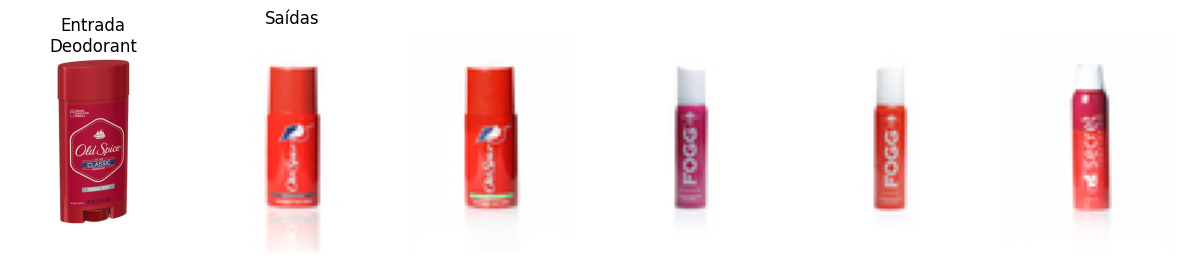

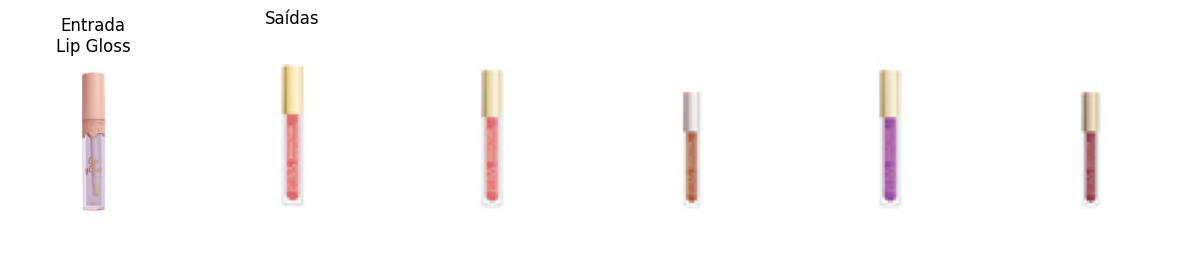

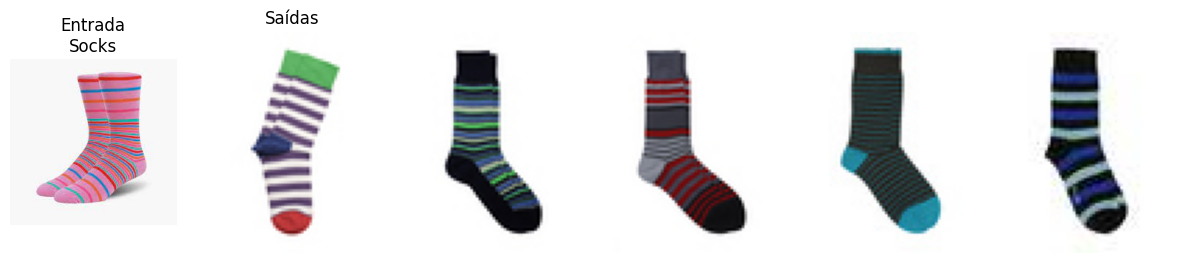

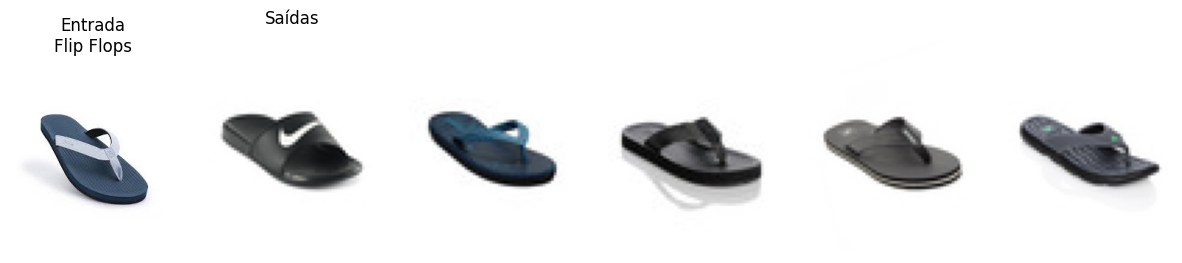

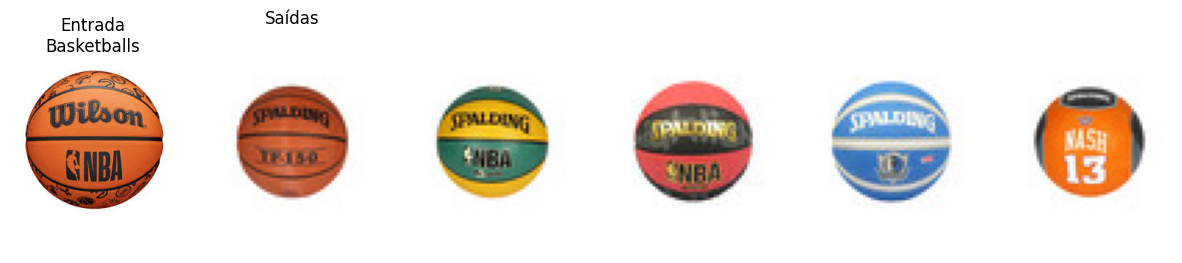

In [8]:
cria_dataset_reduzido(path_dataset, path_kaggle, categorias_utilizadas.keys())

# Carregar modelo pré-treinado (sem camada final)
model = MobileNetV3Small(weights='imagenet', include_top=False, pooling='avg')

# Lista para armazenar caminhos e vetores de características
image_paths = []
image_vectors = []

# Percorrer todas as subpastas dentro de `image_dir`
for category in os.listdir(path_ds_categ):
    category_path = os.path.join(path_ds_categ, category)

    print(category_path, end=" ")

    # Verificar se é um diretório
    if not os.path.isdir(category_path):
      continue

    image_list = [img for img in os.listdir(category_path) if img.endswith(('.jpg', '.png'))]

    # Processar e extrair características de cada imagem
    for img in tqdm(image_list):
        img_path = os.path.join(category_path, img)
        features = extract_features(img_path, model)
        image_vectors.append(features)
        image_paths.append(img_path)

# Converter para array numpy
image_vectors = np.array(image_vectors)

# Salvar as características e os caminhos das imagens
np.save('image_vectors.npy', image_vectors)
np.save('image_paths.npy', image_paths)

for category in categorias_utilizadas.keys():
  query_image = baixa_image_para_query(categorias_utilizadas[category], path_ds_categ, category)
  similar_images = find_similar_images(query_image, image_vectors, image_paths)
  show_images([query_image, *similar_images], category)